In [1]:
import sys
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np
np.set_printoptions(suppress=True, precision=3)

from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# local .py files
sys.path.append(os.path.abspath(os.path.join('..', 'basics')))
from SceneUR10 import SceneUR10WithObs
from Calcs import get_default_path, upsize_path
from Set_scene import set_scene
from Node import Node

from Informed_rrt_star import create_informed_rrt_star
from Opt_informed_rrt_star import create_opt_informed_rrt_star

In [2]:
scene, targets = set_scene(SceneUR10WithObs)

In [3]:
def read_nodes(path: str):
    df_readed = pd.read_csv(path, sep=';')
    new_nodes = []
    for _, current_row in df_readed.iterrows():
        new_nodes.append(Node(int(current_row['id']), np.array(current_row['joint_1':'joint_6']), int(current_row['parent_id']), current_row['cost']))
    new_nodes[0].parent = None
    for i in range(1, len(new_nodes)):
        new_nodes[i].parent = new_nodes[new_nodes[i].parent]
    return new_nodes

def open_list(filename: str):
    with open(filename, "r") as fp:
        obstacles = json.load(fp)
    return obstacles

def show_stats(target_index, path_index, test_index, default_stats, modified_stats):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    fig.suptitle(f'Target {target_index+1}, path {path_index+1}, test {test_index+1}')
    ax1.plot(default_stats[:, 0], default_stats[:, 2], color='r')
    ax2.plot(default_stats[:, 1], default_stats[:, 2], color='r')

    ax1.plot(modified_stats[:, 0], modified_stats[:, 2], color='g')
    ax2.plot(modified_stats[:, 1], modified_stats[:, 2], color='g')
    ax1.set_title('Iters')
    ax2.set_title('Time')
    plt.show()

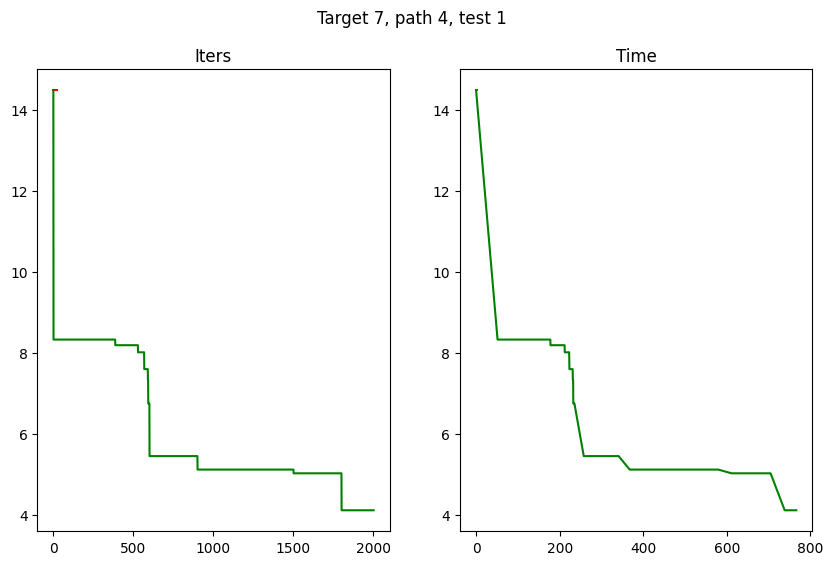

In [4]:
# target --> path --> n_tests --> (maxiters, maxtime)

n_paths_per_target = 5
n_tests_per_path = 20

max_iters = 2000
max_time = 600

# completed 3, 6, 2, 8, 10, 4, 1, 9, 7, 0
# in process 5 (2/5), 11(3/5)
# in queue
current_target_indexes = [6]

for target_index in current_target_indexes:
    # 1) setting variables
    target = targets[target_index]
    scene.set_joints()
    scene.set_target(target)
    start = np.array(scene.j_init)

    # 2) loading initial path
    for path_index in [3]:
        rrt_star_nodes = read_nodes(f'path_finding_for_benckmarking/pre_rrt_star_results/{target_index+1}_{path_index+1}_tree.csv')
        pre_rrt_star_stats = open_list(f'path_finding_for_benckmarking/pre_rrt_star_results/{target_index+1}_{path_index+1}_stats')

        for test_index in range(1):
            scene.clear_obs()
            # 3) Default Informed-RRT*
            default_nodes, default_goal_index, default_stats = create_informed_rrt_star(scene, start, rrt_star_nodes, scene.delta, scene.delta * 20, 1, 1)
            # np.save(f'benchmarking_stats/default/{target_index+1}_{path_index+1}_{test_index+1}.npy', default_stats)
            show_stats(target_index, path_index, test_index, default_stats, np.empty((1, 3)))
            clear_output(wait=True)

            scene.set_obs(pre_rrt_star_stats[2])
            # 4) Modified Informed-RRT* + Optimization
            modified_nodes, modified_goal_index, modified_best_opt_path, modified_stats = create_opt_informed_rrt_star(scene, start, rrt_star_nodes, scene.delta / 2, scene.delta * 20, max_iters, max_time)
            # np.save(f'benchmarking_stats/modified/{target_index+1}_{path_index+1}_{test_index+1}.npy', modified_stats)
            show_stats(target_index, path_index, test_index, default_stats, modified_stats)
            clear_output(wait=True)


In [ ]:
rrt_path = get_default_path(default_nodes, default_goal_index)
ups_rrt_path = upsize_path(rrt_path, scene.delta * 0.5)
scene.vis_path(ups_rrt_path, 0.7)


In [9]:
rrt_path = get_default_path(modified_nodes, modified_goal_index)
ups_rrt_path = upsize_path(rrt_path, scene.delta * 0.5)
scene.vis_path(ups_rrt_path, 0.7)

In [10]:
ups_best_opt_path = upsize_path(np.vstack([start, modified_best_opt_path, modified_nodes[modified_goal_index].get_joints()]), scene.delta * 0.5)
scene.vis_path(ups_best_opt_path, 0.7)